### Import required modules

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, Input, MaxPooling2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import Model, regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from time import time
import csv
import random
import datetime

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from helper import load_and_preprocess_image_no_aug, generator_from_csv, extract_noise_parameters, plot_noise_distributions, visualize_denoising_results

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

## Path to annotation files

In [4]:
# CSV paths
TRAIN_CSV = 'annotations_train.csv'
VAL_CSV   = 'annotations_val.csv'
TEST_CSV  = 'annotations_test.csv'

### For my project, I decided to choose the bsds500 dataset. https://www.kaggle.com/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500
### The dataset is used for segmentation models and consists of 500 images with a size of 481x321 pixels but with different orientations (landscape and portrait).
### I combined all the images into one directory and split them 70%-15%-15% into training, validation, and testing datasets. 
### For each original image, I created three additional pictures with three different types of noise - Gaussian and Poisson and Salt-and-Pepper. The parameters for the generation of noise were chosen randomly.

## Visualization of the distribution of parameters for each type of noise across datasets.

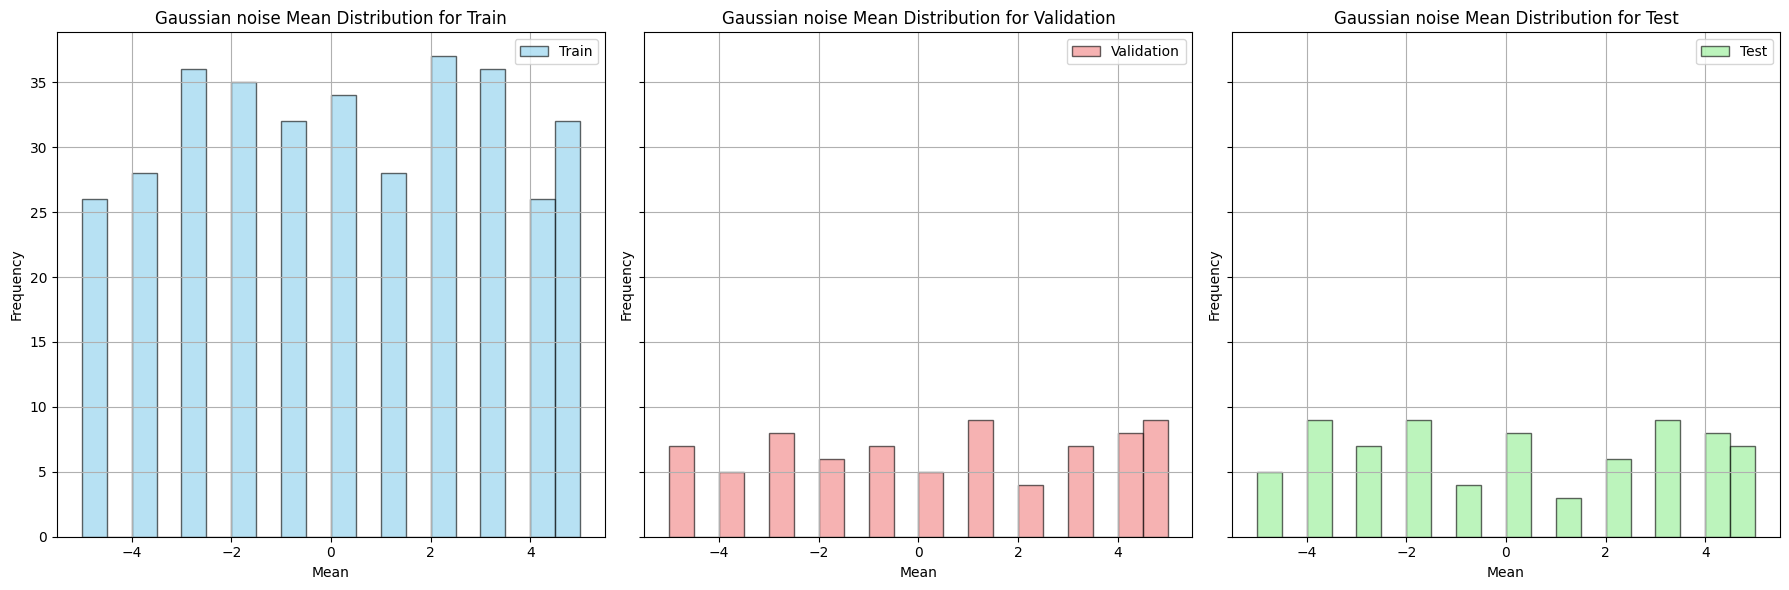

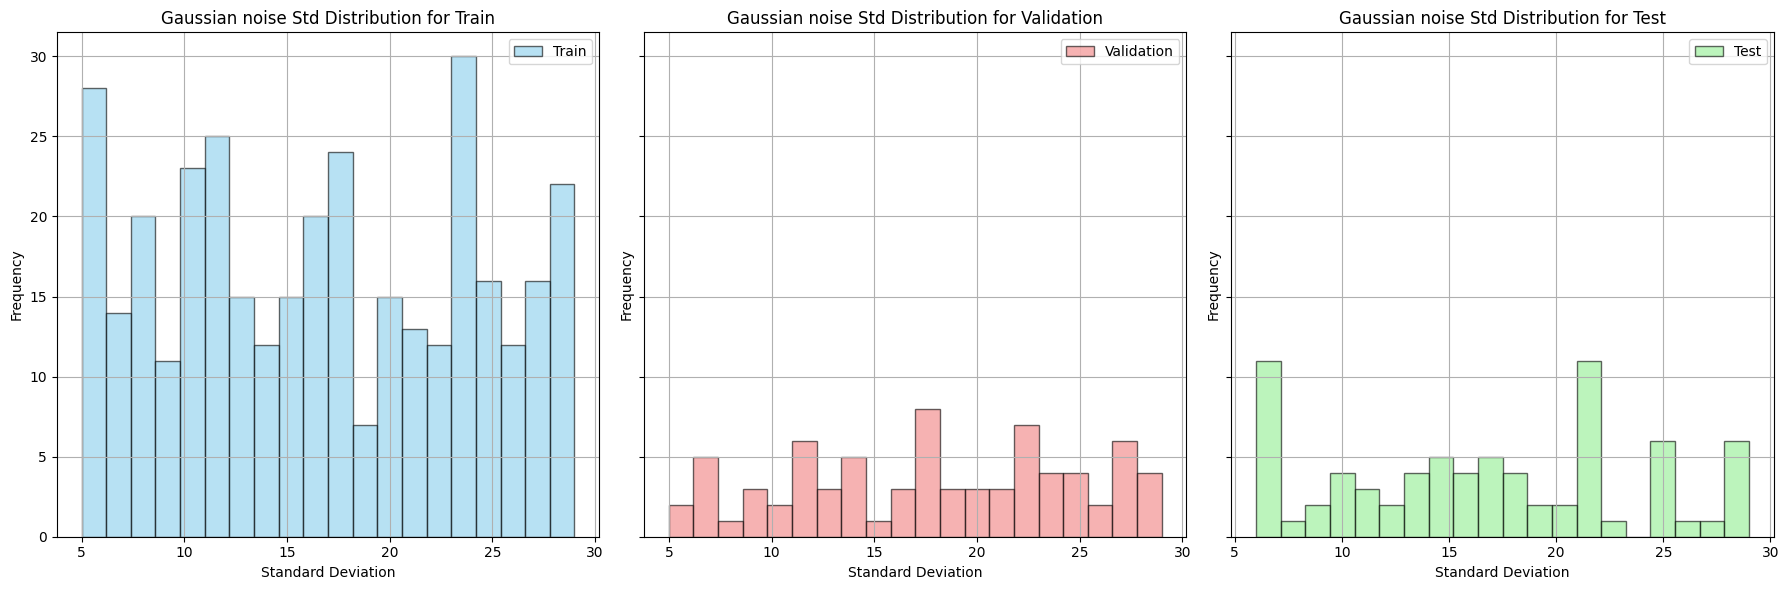

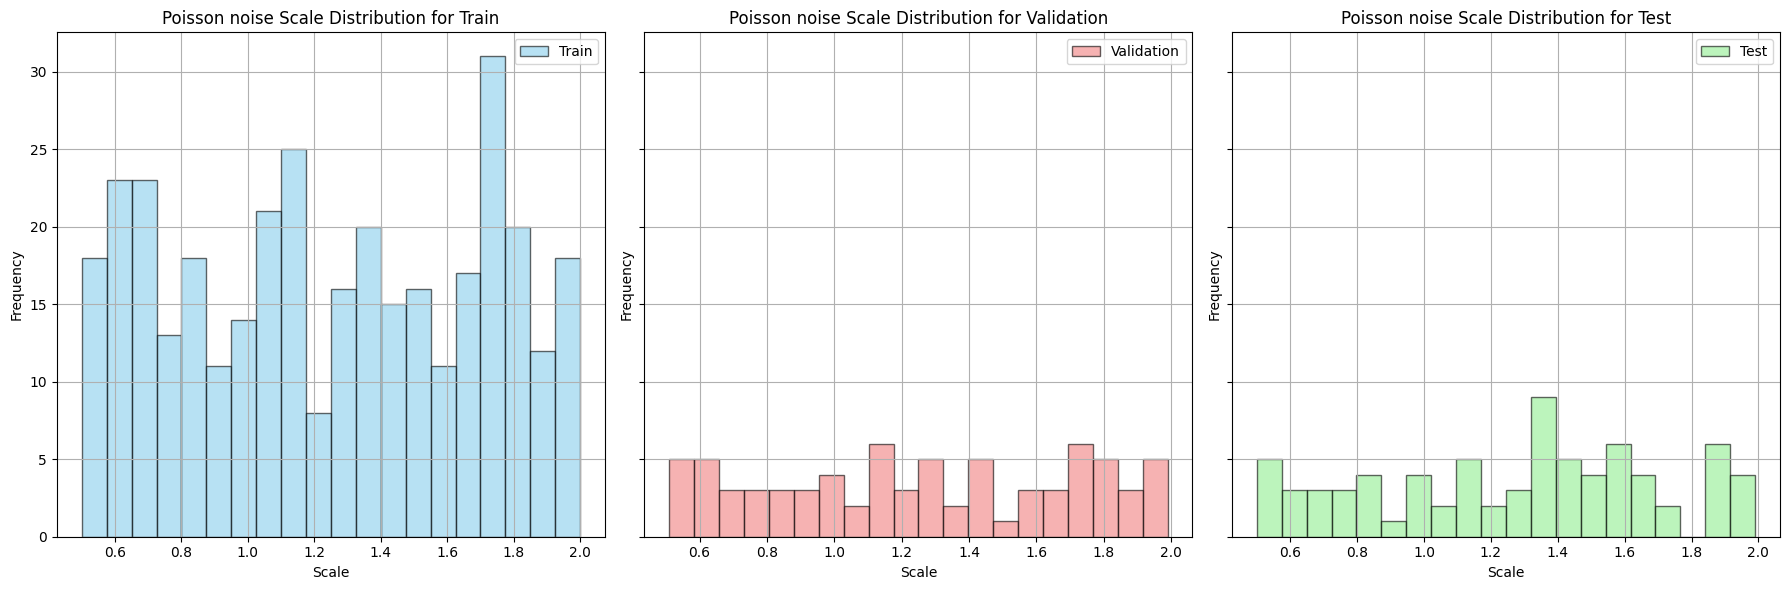

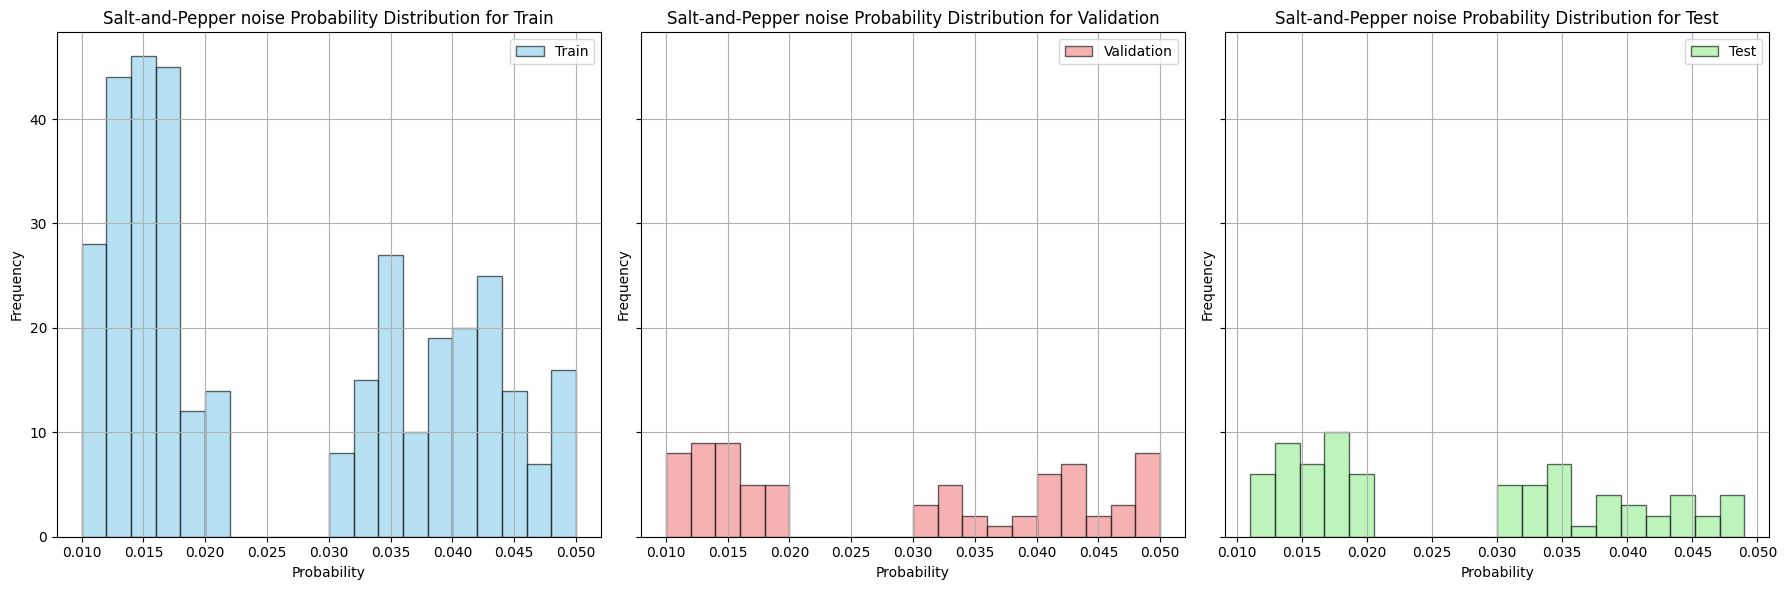

In [5]:
# Extract parameters
train_params = extract_noise_parameters(TRAIN_CSV)
val_params   = extract_noise_parameters(VAL_CSV)
test_params  = extract_noise_parameters(TEST_CSV)

# Plot the distributions
plot_noise_distributions(train_params, val_params, test_params)

### Gaussian Noise Mean:

* Distribution: The distribution is nearly uniform across these integers, with slight variations in height of bars.

* Consistency: The distributions are very similar across the train, validation, and test sets.

### Gaussian Noise Standard Deviation:

* Distribution: The distribution looks more continuous and uniform, though there are still some minor peaks, but overall distribution is flatter.

* Consistency: The distributions for all train, validation and test sets have similar range.

### Poisson Noise Scale:

* Distribution: The distribution is quite flat and uniform with slight variation in the bins, which is what we aimed for.

* Consistency: The distributions of train, val and test data sets look nearly the same.

### Salt and Pepper Noise Probability:

* Distribution: One peak around lower values (0.01 to 0.02), and another peak around higher values (0.03 to 0.05), which is more obvious on test and validation datasets.

* Consistency: The distributions in all datasets have similar shapes, and the middle values are still present, but less frequent.

### Since our images have different orientations, I decided to resize images (256x256 pixels) when loading them into the model.
### Also, for noisy images and the corresponding original images, augmentation (flip, scale, and rotate) is applied randomly during batch loading.
### The batch size is set to 8 images, the number of epochs is 30

In [6]:
# Hyperparameters
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS   = 3
BATCH_SIZE = 8
EPOCHS     = 30

In [7]:
# Data generators for train, val, test sets
train_gen = generator_from_csv(TRAIN_CSV, batch_size=BATCH_SIZE, shuffle=True, augment=True)
val_gen = generator_from_csv(VAL_CSV,   batch_size=BATCH_SIZE, shuffle=False, augment=True)
test_gen  = generator_from_csv(TEST_CSV,  batch_size=BATCH_SIZE, shuffle=False, augment=True)

# Let's guess how many lines are in each CSV -header
train_lines = sum(1 for _ in open(TRAIN_CSV)) - 1
val_lines = sum(1 for _ in open(VAL_CSV))   - 1
test_lines = sum(1 for _ in open(TEST_CSV))  - 1

# Steps per epoch
steps_per_epoch = train_lines // BATCH_SIZE
validation_steps = val_lines   // BATCH_SIZE
test_steps = test_lines  // BATCH_SIZE

### Settings for Tensorboard

In [7]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

### I decided to use mean absolute error (MAE) as our primary loss function and monitoring metric for denoising
### Key Takeaways:

* MAE is more robust to outliers, and this is the important factor for you since you are generating different types of noises.
* MAE is better at preserving sharp details (edges, textures) than MSE, which is crucial for denoising natural images.
* The noise types you're using (especially salt-and-pepper) often produce outliers, for which MAE is more robust.

## Callback settings

In [8]:
# Define callbacks using mae

reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5,
                              patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_mae', patience=10,
                           restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('unet_best_model.h5', monitor='val_mae',
                             save_best_only=True, verbose=1)

## I decided to use a U-net neural network instead of a network like DnCNN for variety. Why U-net? One of the reasons was the article (https://www.sciltp.com/journals/aim/2024/1/445/363).
## According to tests, this network shows quite good results for denoising tasks. And I also decided to check how this architecture will cope with denoising :)

In [9]:
def build_unet_with_bn(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1) #Batch normalization added
    c1 = layers.ReLU()(c1)
    c1 = layers.Conv2D(64, (3, 3), padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)  #Batch normalization added
    c1 = layers.ReLU()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), padding='same')(p1)
    c2 = layers.BatchNormalization()(c2) #Batch normalization added
    c2 = layers.ReLU()(c2)
    c2 = layers.Conv2D(128, (3, 3), padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)  #Batch normalization added
    c2 = layers.ReLU()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), padding='same')(p2)
    c3 = layers.BatchNormalization()(c3) #Batch normalization added
    c3 = layers.ReLU()(c3)
    c3 = layers.Conv2D(256, (3, 3), padding='same')(c3)
    c3 = layers.BatchNormalization()(c3) #Batch normalization added
    c3 = layers.ReLU()(c3)

    # Decoder
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), padding='same')(u4)
    c4 = layers.BatchNormalization()(c4) #Batch normalization added
    c4 = layers.ReLU()(c4)
    c4 = layers.Conv2D(128, (3, 3), padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)  #Batch normalization added
    c4 = layers.ReLU()(c4)

    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), padding='same')(u5)
    c5 = layers.BatchNormalization()(c5) #Batch normalization added
    c5 = layers.ReLU()(c5)
    c5 = layers.Conv2D(64, (3, 3), padding='same')(c5)
    c5 = layers.BatchNormalization()(c5) #Batch normalization added
    c5 = layers.ReLU()(c5)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    return model


In [10]:
model = build_unet_with_bn(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
model.compile(optimizer='adam', loss='mae', metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Fit the model
history = model.fit(
    x=train_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stop, checkpoint, tensorboard_callback]
)

In [ ]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['mae'], '.-', epochs, h['val_mae'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('mae')
    plt.legend(['Train', 'Validation'])
        
    print('Train MAE     ', h['mae'][-1])
    print('Validation MAE', h['val_mae'][-1])
    
plot_history(history)

In [ ]:
new_test_gen  = generator_from_csv(TRAIN_CSV,  batch_size=BATCH_SIZE, shuffle=True, augment=False)
visualize_denoising_results(model, new_test_gen, num_images=6)